In [19]:
#to center the output images
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


In [20]:
#for loading images from google drive
#from google.colab import drive
#drive.mount('/content/drive')

#load images from google drive (must authenticate into the google drive account and use code cell [2] above)
#contentImagePath = '/content/drive/MyDrive/Colab Notebooks/images/Octopus.jpg'
#styleImagePath = '/content/drive/MyDrive/Colab Notebooks/images/Rainbow.jpg'

In [21]:
# choosing to load from URL or session storage
# imgur sample images : https://imgur.com/a/eIn5ERE
num = input('Enter 1 for session storage (upload from the folder icon on the left)\nOr enter 2 for URL\n')
if num == '1':
  #load images from session drive (must upload images from the Files toggle on the left)
  contentImagePath = '/content/Octopus.jpg'
  styleImagePath = '/content/Rainbow.jpg'
else:
  #load images from URL
  contentImagePath = 'https://i.imgur.com/rp09aCO.jpg'
  styleImagePath = 'https://i.imgur.com/muRv2pF.jpg'



Enter 1 for session storage(upload from the folder icon on the left)
Or enter 2 for URL
2


if the model is too slow, make sure that the model is running on GPU, from the resources gauge on the top right -> change runtime type -> GPU
model parameters and images used can be changed from the top of the code
Proccessing on: cuda
https://i.imgur.com/rp09aCO.jpg
Loading From URL
https://i.imgur.com/muRv2pF.jpg
Loading From URL
learning rate = 0.007, #steps = 300, #subplots = 6:
Starting ...


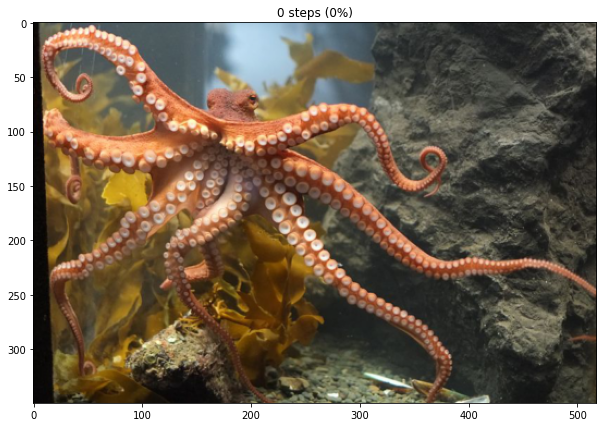

30 steps (10%) , Total loss: 5487644
60 steps (20%) , Total loss: 3979509


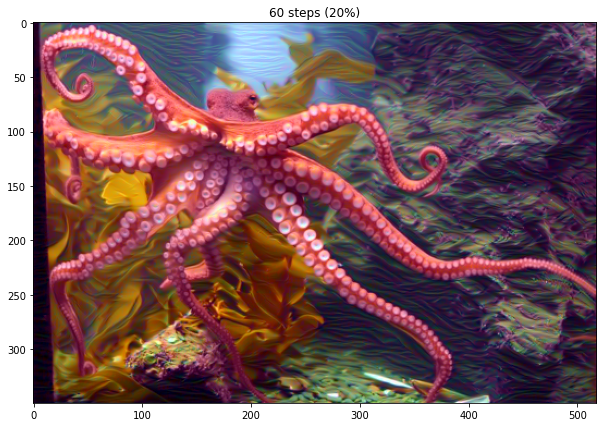

90 steps (30%) , Total loss: 2435779
120 steps (40%) , Total loss: 1678608


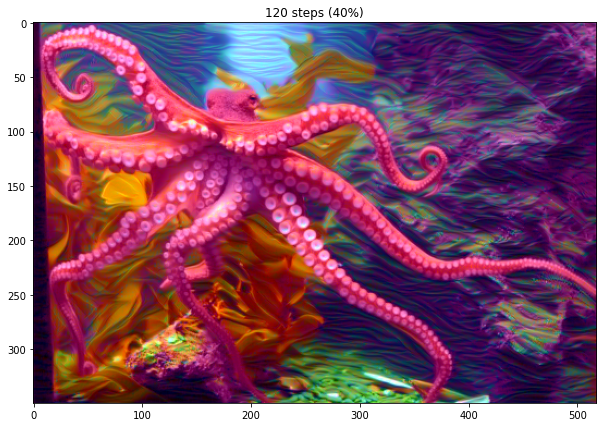

150 steps (50%) , Total loss: 1254728
180 steps (60%) , Total loss: 896336


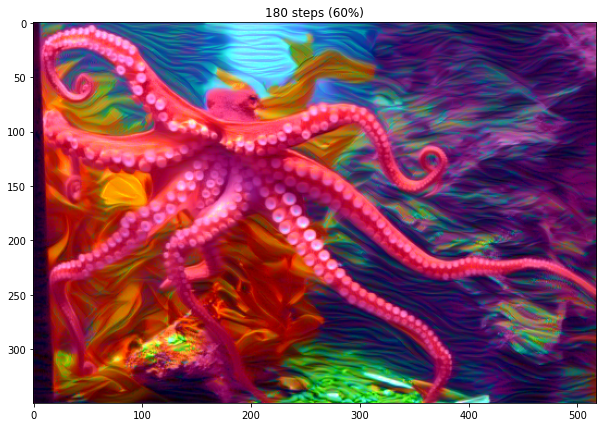

210 steps (70%) , Total loss: 623825
240 steps (80%) , Total loss: 446862


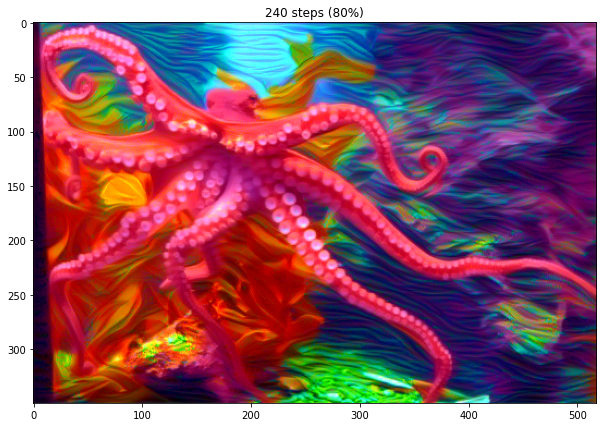

270 steps (90%) , Total loss: 345026
300 steps (100%) , Total loss: 284877


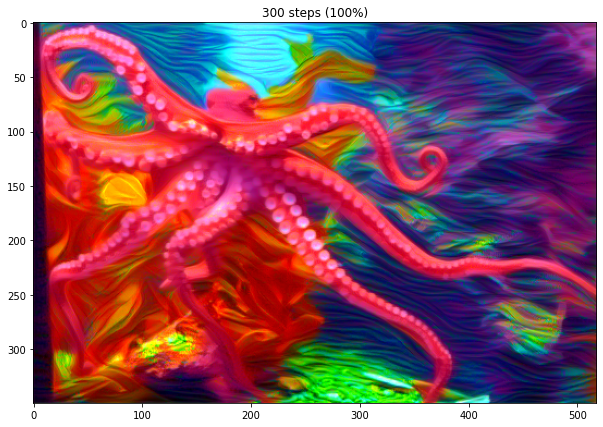

Done


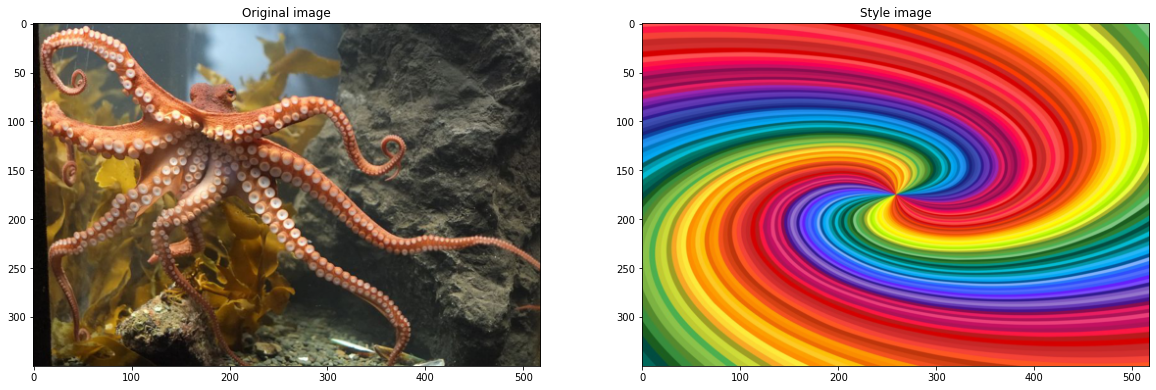

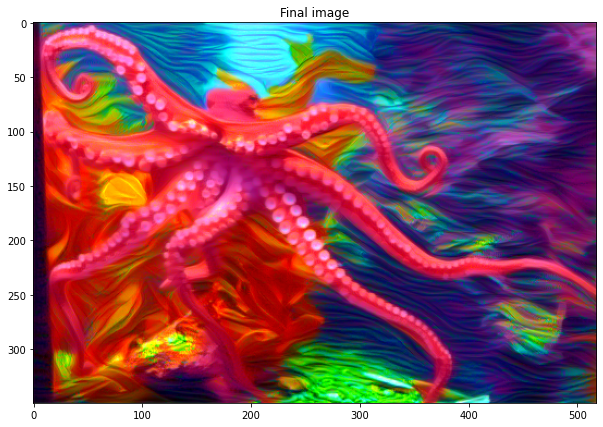

In [22]:
#make sure that the model is running on GPU, from the resources gauge on the top right -> change runtime type -> GPU
print('if the model is too slow, make sure that the model is running on GPU, from the resources gauge on the top right -> change runtime type -> GPU')
print('model parameters and images used can be changed from the top of the code')
# import resources
get_ipython().run_line_magic('matplotlib', 'inline')

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

import requests

max_size=350
plt.rcParams["figure.figsize"] = (12,7)

# iteration hyperparameters
learningrate = 0.007
steps = 300  # decide how many iterations to update your image (5000)
n = 5  # number of intermediate subplots (odd number)
show_every = steps // n

# weights for each style layer 
# weighting earlier layers more will result in larger style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 5.0,
                 'conv2_1': 1.0,
                 'conv3_1': 0.3,
                 'conv4_1': 0.2}

content_weight = 1  # alpha
style_weight = 1000  # beta

# ## Load in VGG13 (features)
# 
# VGG13 is split into two portions:
#  `vgg13.features`, which are all the convolutional and pooling layers
#  `vgg13.classifier`, which are the three linear, classifier layers at the end
# 
# We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.


# get the "features" portion of VGG13 (we will not need the "classifier" portion)
vgg = models.vgg13(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Proccessing on: " + str(device))
vgg.to(device)

# ### Load in Content and Style Images
# 
# You can load in any images you want! Below, we've provided a helper function for loading in any type and size of
# image. The `load_image` function also converts images to normalized Tensors.
# 
# Additionally, it will be easier to have smaller images and to squish the content and style images so that they are
# of the same size.


def load_image(img_path, shape=None):
    # Load in and transform an image, making sure the image is <= max_size pixels in the x-y dims.
    print(img_path)

    if num == '1':
      image = Image.open(img_path).convert('RGB')
      print('Loading from session storage')

    else:
      image = Image.open(requests.get(img_path, stream=True).raw).convert('RGB')
      print('Loading From URL')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image


# Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

# load in content and style image from URL
content = load_image(contentImagePath).to(device)
# Resize style to match content, makes code easier
style = load_image(styleImagePath, shape=content.shape[-2:]).to(device)


# # Style Transfer with Deep Neural Networks

# style transfer uses the features found in the 13-layer VGG Network, which is comprised of a series of convolutional
# and pooling layers, and a few fully-connected layers

# ### Separating Style and Content

# Style transfer relies on separating the content and style of an image. Given one content image and one style image,
# we aim to create a new, _target_ image which should contain our desired content and style components:  objects and
# their arrangement are similar to that of the content image style, colors, and textures are similar to that of
# the style image

# we'll use a pre-trained VGG13 Net to extract content or style features from a passed in image.
# We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image
# until we get a result that we want.


# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


# ---
# ## VGG13 Layers
# 
# To get the content and style representations of an image, we have to pass an image forward through the VGG13
# network until we get to the desired layer(s) and then get the output from that layer.


# print out VGG13 structure so you can see the names of various layers
#print(vgg)


# ## Content and Style Features
# 
# complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style
# representation_.


def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    # Complete mapping layer names of PyTorch's VGGNet to names from the paper
    # Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '15': 'conv4_1',
                  '17': 'conv4_2'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features


# ---
# ## Gram Matrix 
# 
# The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth,
# `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
# Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size()` , Reshape that tensor so
# that the spatial dimensions are flattened , Calculate the gram matrix by multiplying the reshaped tensor by it's
# transpose
#
# Complete the `gram_matrix` function.


def gram_matrix(tensor):
    # Calculate the Gram Matrix of a given tensor Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix

    # get the batch_size, depth, height, and width of the Tensor

    _, d, h, w = tensor.size()
    # reshape it, so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram


# ## Putting it all Together
# 
# Now that we've written functions for extracting features and computing the gram matrix of a given convolutional
# layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram
# matrices for each layer in our style representation.


# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our content image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)


# ## Updating the Target & Calculating Losses


optimizer = optim.Adam([target], lr=learningrate)

print('learning rate = ' + str(learningrate) + ', #steps = ' + str(steps) + ', #subplots = ' + str(n + 1) + ':')
print('Starting ...')
#fig, axes = plt.subplots(2, int(np.ceil((n + 1) / 2)), figsize=(20, 10))
#axes = axes.flatten()
#axes[0].imshow(im_convert(content))
#axes[0].title.set_text('0 steps (0%)')
#plt.title.set_text('0 steps (0%)')
plt.title('0 steps (0%)')
plt.imshow(im_convert(content))
plt.show()
for ii in range(1, steps + 1):

    # get the features from your target image
    # Then calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape

        # Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)

        # get the "style" style representation
        style_gram = style_grams[layer]
        # Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the total loss
    total_loss = style_weight * style_loss + content_weight * content_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if ii % (show_every/2) == 0:
        print(str(ii) + ' steps (' + str(int(np.ceil(ii / steps * 100))) + '%) , Total loss:', int(total_loss.item()))

    if ii % show_every == 0:
        #axes[ii // show_every].title.set_text(str(ii) + ' steps (' + str(int(np.ceil(ii / steps * 100))) + '%)')
        #axes[ii // show_every].imshow(im_convert(target))
        plt.title(str(ii) + ' steps (' + str(int(np.ceil(ii / steps * 100))) + '%)')
        plt.imshow(im_convert(target))
        plt.show()

print("Done")

# display the original image, style image, and final image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.title.set_text('Original image')
ax1.imshow(im_convert(content))
ax2.title.set_text('Style image')
ax2.imshow(im_convert(style))
plt.show()

plt.title('Final image')
plt.imshow(im_convert(target))

plt.show()
